# Goodreads books recommender system

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from ast import literal_eval
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

### Books

#### Cleaning

In [2]:
books_df = pd.read_csv('https://raw.githubusercontent.com/malcolmosh/goodbooks-10k/master/books_enriched.csv', index_col=[0], converters={"genres": literal_eval})

In [3]:
# use goodreads book id instead of the arbitrary id
books_df["book_id"] = books_df.goodreads_book_id

In [4]:
# Dropping unneeded columns
books_df = books_df.drop(columns=["description", "image_url", "small_image_url", "index", "authors_2", "best_book_id", "goodreads_book_id"], errors = 'ignore')

In [5]:
genres = set(books_df["genres"].explode())
genres

{'art',
 'biography',
 'books',
 'business',
 'chick-lit',
 'christian',
 'classics',
 'comics',
 'contemporary',
 'cookbooks',
 'crime',
 'fantasy',
 'fiction',
 'gay-and-lesbian',
 'graphic-novels',
 'historical-fiction',
 'history',
 'horror',
 'humor-and-comedy',
 'manga',
 'memoir',
 'music',
 'mystery',
 'nonfiction',
 'paranormal',
 'philosophy',
 'poetry',
 'psychology',
 'religion',
 'romance',
 'science',
 'science-fiction',
 'self-help',
 'spirituality',
 'sports',
 'suspense',
 'thriller',
 'travel',
 'young-adult'}

In [6]:
# Keep only english books.
books_df = books_df[books_df.language_code == 'eng']

In [7]:
# drop books with duplicated title
books_df = books_df.drop_duplicates(subset = ['title'])

In [8]:
# transform list columns to list
books_df['authors'] = books_df['authors'].apply(lambda x: x.strip('[]').replace("'","").split(", "))

#### EDA

In [9]:
books_df.head()

,authors,average_rating,book_id,books_count,genres,isbn,isbn13,language_code,original_publication_year,original_title,...,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,ratings_count,title,work_id,work_ratings_count,work_text_reviews_count
0,[Suzanne Collins],4.34,2767052,272,"[young-adult, fiction, fantasy, science-fictio...",439023483,9.780439e+12,eng,2008.0,The Hunger Games,...,66715,127936,560092,1481305,2706317,4780653,"The Hunger Games (The Hunger Games, #1)",2792775,4942365,155254
1,"[J.K. Rowling, Mary GrandPré]",4.44,3,491,"[fantasy, fiction, young-adult, classics]",439554934,9.780440e+12,eng,1997.0,Harry Potter and the Philosopher's Stone,...,75504,101676,455024,1156318,3011543,4602479,Harry Potter and the Sorcerer's Stone (Harry P...,4640799,4800065,75867
2,[Stephenie Meyer],3.57,41865,226,"[young-adult, fantasy, romance, fiction, paran...",316015849,9.780316e+12,eng,2005.0,Twilight,...,456191,436802,793319,875073,1355439,3866839,"Twilight (Twilight, #1)",3212258,3916824,95009
3,[Harper Lee],4.25,2657,487,"[classics, fiction, historical-fiction, young-...",61120081,9.780061e+12,eng,1960.0,To Kill a Mockingbird,...,60427,117415,446835,1001952,1714267,3198671,To Kill a Mockingbird,3275794,3340896,72586
4,[F. Scott Fitzgerald],3.89,4671,1356,"[classics, fiction, historical-fiction, romance]",743273567,9.780743e+12,eng,1925.0,The Great Gatsby,...,86236,197621,606158,936012,947718,2683664,The Great Gatsby,245494,2773745,51992


In [10]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9645 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   authors                    9645 non-null   object 
 1   average_rating             9645 non-null   float64
 2   book_id                    9645 non-null   int64  
 3   books_count                9645 non-null   int64  
 4   genres                     9645 non-null   object 
 5   isbn                       9026 non-null   object 
 6   isbn13                     9110 non-null   float64
 7   language_code              9645 non-null   object 
 8   original_publication_year  9625 non-null   float64
 9   original_title             9085 non-null   object 
 10  pages                      9576 non-null   float64
 11  publishDate                9637 non-null   object 
 12  ratings_1                  9645 non-null   int64  
 13  ratings_2                  9645 non-null   int64

In [11]:
# most rated books
books_df.sort_values('ratings_count', ascending = False)[["title","authors","average_rating", "ratings_count"]].iloc[0:20]

,title,authors,average_rating,ratings_count
0,"The Hunger Games (The Hunger Games, #1)",[Suzanne Collins],4.34,4780653
1,Harry Potter and the Sorcerer's Stone (Harry P...,"[J.K. Rowling, Mary GrandPré]",4.44,4602479
2,"Twilight (Twilight, #1)",[Stephenie Meyer],3.57,3866839
3,To Kill a Mockingbird,[Harper Lee],4.25,3198671
4,The Great Gatsby,[F. Scott Fitzgerald],3.89,2683664
5,The Fault in Our Stars,[John Green],4.26,2346404
6,The Hobbit,[J.R.R. Tolkien],4.25,2071616
7,The Catcher in the Rye,[J.D. Salinger],3.79,2044241
9,Pride and Prejudice,[Jane Austen],4.24,2035490
8,"Angels & Demons (Robert Langdon, #1)",[Dan Brown],3.85,2001311


In [12]:
# authors of top 100 rated books
top_100 = books_df.sort_values(['average_rating'], ascending = False).iloc[0:100,:]

# transform authors to list and get top 15 authors that appear in top 100 books
authors_top_100 = pd.Series([x for item in top_100['authors'] for x in item]).value_counts().to_frame('counts').reset_index()
authors_top_100 = authors_top_100.iloc[0:15,:]

In [13]:
sns.set_style('darkgrid')
sns.set_palette('cividis')

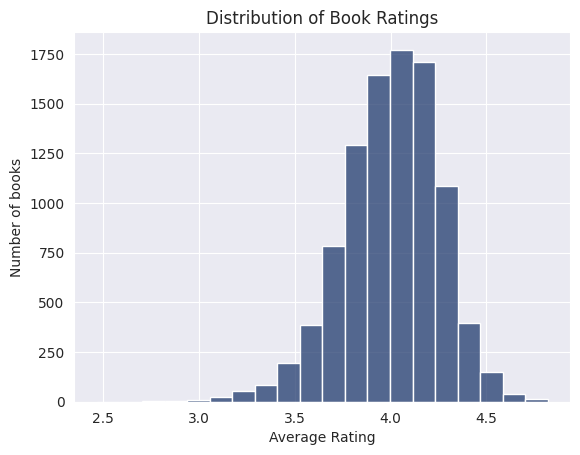

In [14]:
ax = sns.histplot(data=books_df, x="average_rating", bins=20)
ax.set_title("Distribution of Book Ratings")
ax.set_xlabel("Average Rating")
ax.set_ylabel("Number of books")
plt.show()

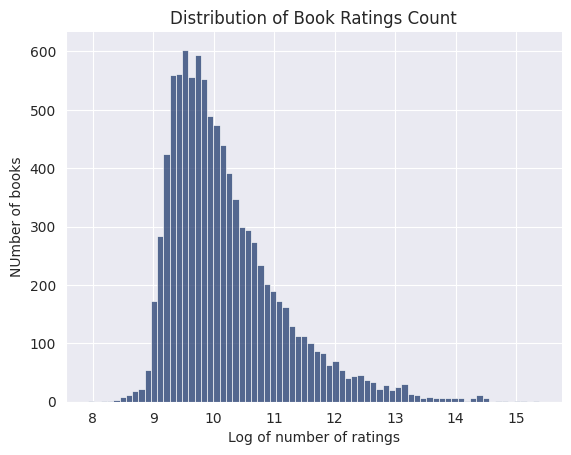

In [15]:
temp_books = pd.DataFrame()
temp_books["ratings_count_log"]=np.log(books_df.ratings_count)
ax = sns.histplot(data = temp_books, x = "ratings_count_log")
ax.set_title("Distribution of Book Ratings Count")
ax.set_xlabel("Log of number of ratings")
ax.set_ylabel("NUmber of books")
sns.despine()
plt.show()

<AxesSubplot: title={'center': 'Scatterplot of average book rating vs number of ratings'}, xlabel='ratings_count', ylabel='average_rating'>

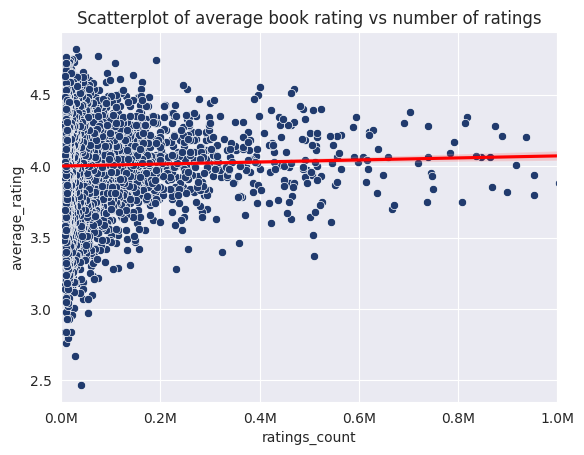

In [16]:
ax = sns.scatterplot(data = books_df, x = "ratings_count", y = "average_rating")
ax.set(xlim=(0, 1000000))
ax.set_title("Scatterplot of average book rating vs number of ratings")
ax.set_xlabel("Number of ratings")
ax.set_ylabel("Rating")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{(x/1000000)}M'))
sns.regplot(data=books_df, x="ratings_count", y="average_rating", scatter=False, color='r')

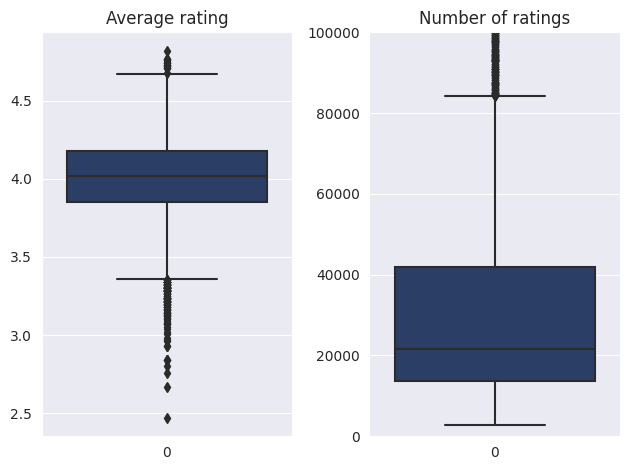

In [17]:
columns_to_plot = ['average_rating', 'ratings_count']
fig, axes = plt.subplots(ncols=len(columns_to_plot))
for column, axis in zip(columns_to_plot, axes):
    if column == 'ratings_count':
        sns.boxplot(data=books_df[column], ax=axis).set(ylim=(0, 100000))
        axis.set_title('Number of ratings')
    else:
        sns.boxplot(data=books_df[column], ax=axis)
        axis.set_title('Average rating')
plt.tight_layout()
plt.show()

### Ratings

In [18]:
ratings_df = pd.read_csv('reviews_updated2.csv')

In [19]:
# remove index column
ratings_df = ratings_df.drop(columns=["Unnamed: 0"])

In [40]:
# convert date to timestamp, and keep only the date
ratings_df["date_added"] = pd.to_datetime(ratings_df.date_added, format='%Y/%m/%d', utc = True)
ratings_df["date_added"] = ratings_df.date_added.dt.date


In [ ]:
# filter out reviews preceding goodreads site
ratings_df = ratings_df[ratings_df.date_added >= pd.Timestamp(year=2000, month=1, day=1)]

In [42]:
ratings_df.head()

,user_id,book_id,rating,date_added
0,8842281e1d1347389f2ab93d60773d4d,16981,3,2016-12-05
1,8842281e1d1347389f2ab93d60773d4d,27161156,0,2016-11-10
2,8842281e1d1347389f2ab93d60773d4d,4866,0,2015-08-19
3,8842281e1d1347389f2ab93d60773d4d,23158207,3,2015-07-29
4,8842281e1d1347389f2ab93d60773d4d,22318578,5,2015-06-07


In [21]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4522470 entries, 0 to 4522469
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user_id     object
 1   book_id     int64 
 2   rating      int64 
 3   date_added  object
dtypes: int64(2), object(2)
memory usage: 138.0+ MB


In [ ]:
len(ratings_df["user_id"].unique())

~35k users

In [ ]:
ratings_df[["rating"]].describe()

In [ ]:
ratings_df.groupby('user_id')['book_id'].count().head()

In [ ]:
ax = sns.boxplot(y=ratings_df.groupby('user_id')['book_id'].count(), orient="v")
ax.set_ylim(0, 100)
ax.set_ylabel("Number of ratings")
ax.set_title("Number of ratings by user")

### Other tables
Don't know if these will be needed for our purpose:
- **tags** - Shelf name (genre) and count of the books in that shelf
- **book_tags** - Shelves with the count for each book
- **to_read** - books to read for user

In [ ]:
tags_df = pd.read_csv('https://raw.githubusercontent.com/malcolmosh/goodbooks-10k/master/tags.csv')

In [ ]:
book_tags_df = pd.read_csv('https://raw.githubusercontent.com/malcolmosh/goodbooks-10k/master/book_tags.csv')

In [ ]:
to_read_df = pd.read_csv('https://raw.githubusercontent.com/malcolmosh/goodbooks-10k/master/to_read.csv')

## Splits

there is no temporal data about the reviews, hence random is the best we can do... (I think)

In [55]:
len(train.user_id.unique())

298444

In [48]:
train, test = train_test_split(ratings_df.sort_values(by='date_added'), test_size=0.2, shuffle = False)
pivot_table = train.pivot(index='user_id', columns='book_id', values='rating')
# matrix = pivot_table.to_numpy()

## Naive Baseline

fills the gaps with median

In [ ]:
def naive(matrix):
    medians = []
    for i in range(matrix.shape[1]):
        medians.append(np.nanmedian(matrix[:,i]))
    
    medians = []
    for i in range(matrix.shape[1]):
        medians.append(np.nanmedian(matrix[:,i]))
    medians = np.array(medians)
    
    for i,row in enumerate(matrix):
        matrix[i][np.isnan(row)] = medians[np.isnan(row)]
    return matrix

## Testing

dummy testing function, because it will change based on how the new data will look like

In [ ]:
def evaluate(matrix):
    return 10

In [ ]:
evaluate(naive(matrix.copy()))
